In [31]:
%matplotlib inline
import time
import os
import numpy as np
from glob import glob
from skimage import io
from matplotlib import pyplot as plt
from helperfuncs import image_slice,imm
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import *
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.losses import binary_crossentropy
from keras.models import load_model
import labelmask as lm
from ast import literal_eval
import shutil


In [5]:
directory = open('path_to_datafolder.txt','r').readlines()[0].strip('\n')

In [2]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)

def down(filters, input_):
    down_ = Conv2D(filters, (3, 3), padding='same')(input_)
    down_ = BatchNormalization(epsilon=1e-4)(down_)
    down_ = Activation('relu')(down_)
    down_ = Conv2D(filters, (3, 3), padding='same')(down_)
    down_ = BatchNormalization(epsilon=1e-4)(down_)
    down_res = Activation('relu')(down_)
    down_pool = MaxPooling2D((2, 2), strides=(2, 2))(down_)
    return down_pool, down_res

def up(filters, input_, down_):
    up_ = UpSampling2D((2, 2))(input_)
    up_ = concatenate([down_, up_], axis=3)
    up_ = Conv2D(filters, (3, 3), padding='same')(up_)
    up_ = BatchNormalization(epsilon=1e-4)(up_)
    up_ = Activation('relu')(up_)
    up_ = Conv2D(filters, (3, 3), padding='same')(up_)
    up_ = BatchNormalization(epsilon=1e-4)(up_)
    up_ = Activation('relu')(up_)
    up_ = Conv2D(filters, (3, 3), padding='same')(up_)
    up_ = BatchNormalization(epsilon=1e-4)(up_)
    up_ = Activation('relu')(up_)
    return up_

def get_unet_1024(input_shape, num_classes=1):
    inputs = Input(shape=input_shape)

    #down0b, down0b_res = down(8, inputs)
    down0a, down0a_res = down(24, inputs)
    down0, down0_res = down(64, down0a)
    down1, down1_res = down(128, down0)
    down2, down2_res = down(256, down1)
    down3, down3_res = down(512, down2)
    down4, down4_res = down(768, down3)
    
    center = Conv2D(768, (3, 3), padding='same')(down4)
    center = BatchNormalization(epsilon=1e-4)(center)
    center = Activation('relu')(center)
    center = Conv2D(768, (3, 3), padding='same')(center)
    center = BatchNormalization(epsilon=1e-4)(center)
    center = Activation('relu')(center)

    up4 = up(768, center, down4_res)
    up3 = up(512, up4, down3_res)
    up2 = up(256, up3, down2_res)
    up1 = up(128, up2, down1_res)
    up0 = up(64, up1, down0_res)
    up0a = up(24, up0, down0a_res)
    #up0b = up(8, up0a, down0b_res)

    classify = Conv2D(num_classes, (1, 1), activation='sigmoid', name='final_layer')(up0a)

    model = Model(inputs=inputs, outputs=classify)

    return model


In [16]:
model = get_unet_1024((256,256,1))
model.load_weights('models/fifth_trained_model_unet3_weights.h5',by_name = True)

In [17]:
model.compile(loss=bce_dice_loss, optimizer=Adam(lr=1e-4), metrics=[dice_coef])

In [19]:
test_data = io.imread(directory+'/med_sliced_images/101729F_plasma15sec_Mh370kx__0000_5120.png',as_grey=True)
test_data = test_data - test_data.mean()
test_data = test_data.reshape((1,)+test_data.shape+(1,))

In [20]:
test_data.shape

(1, 256, 256, 1)

In [21]:
test_out = model.predict(test_data)

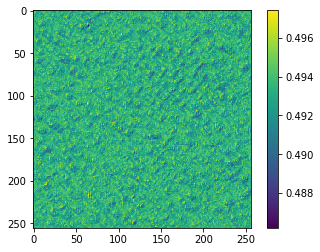

In [23]:
plt.imshow(test_out[0,:,:,:].reshape((256,256)))
plt.colorbar()

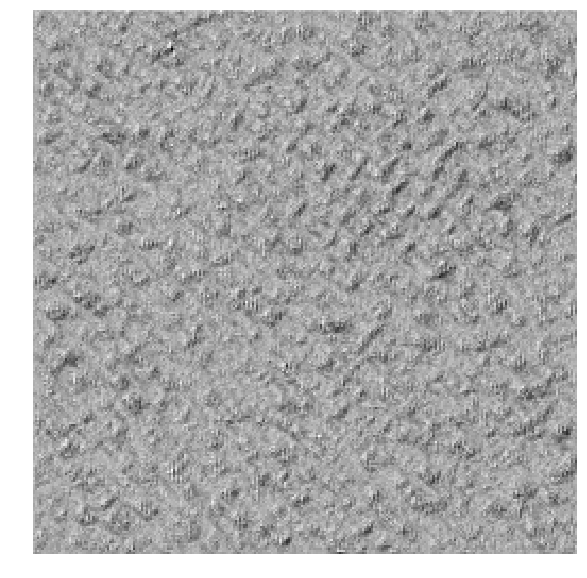

In [24]:
imm(test_out[0,:,:,:].reshape((256,256)))

In [25]:
def image_slice_small(directory):
    """Used to break up the 1024x1024 images into 64x64 segments takes a
     diretory that is the source. This is only for creating training
     dataset. Throws out regions of the masks and images with no identified
     particles so that training set will have better balance of positive and
     negative pixels."""
    image_file_list = glob(directory+'/images/*.png')
    image_new_directory = directory + '/small_sliced_images/'
    if os.path.isdir(image_new_directory) != True:
        os.mkdir(image_new_directory)
    label_file_list = glob(directory+'/labels/*.png')
    label_new_directory = directory + '/small_sliced_labels/'
    if os.path.isdir(label_new_directory) != True:
        os.mkdir(label_new_directory)
    image_name_list = [name.split('/')[-1].split('.')[0] for name in image_file_list]
    label_name_list = [name.split('/')[-1].split('.')[0] for name in label_file_list]
    if len(image_name_list) != len(label_name_list):
        raise RuntimeError('different number of images and labels')
    if image_name_list != label_name_list:
        raise RuntimeError('images and labels did not match')
    for idx, file in enumerate(image_file_list):
        image2split = io.imread(file, as_grey=True)
        label2split = io.imread(label_file_list[idx], as_grey=True)
        for x in range(0,15*64,64):
            for y in range(0,15*64,64):
                image = image2split[x:x+64,y:y+64]
                label = label2split[x:x+64,y:y+64]
                if np.any(np.isin([1],label)) == False:
                    pass
                else:
                    image_name = image_name_list[idx]+ '_' + str(x)+ str(y) + '.png'
                    label_name = image_name_list[idx]+ '_' + str(x)+ str(y) + '.png'
                    plt.imsave(image_new_directory+image_name,image, cmap='gray')
                    plt.imsave(label_new_directory+label_name,label, cmap='gray')
    print('done!')


In [35]:
def txt_reader(file):
    txt_info = open(file,'r')
    txt = []
    centers = []
    radii = []
    for line in txt_info:
        if line == '\n':
            pass
        else:
            line = line.strip('\n')
            txt.append(line)
    center_stop = txt.index('Radius Size:')
    radius_stop = txt.index('Defect Label:')
    for loc in txt[1:center_stop]:
        centers.append(literal_eval(loc))
    for loc in txt[center_stop+1:radius_stop] :
        radii.append(int(loc))
    image_size = literal_eval(txt[-1])
    return centers, radii, image_size


def spot_maker(location, radius, label_mask):
    for x in np.arange(location[0]-radius,location[0]+radius,1):
        for y in np.arange(location[1]-radius,location[1]+radius,1):
            dx = x - location[0]
            dy = y - location[1]
            if np.sqrt((dx**2+dy**2)) <= radius \
            and int(x) < label_mask.shape[0] and int(y) < label_mask.shape[1]:
                label_mask[int(y),int(x)] = 1
    return label_mask

def mask_maker(file):
    centers, radii, image_size = txt_reader(file)
    label_mask = np.zeros(image_size)
    for idx,radius in enumerate(radii):
        label_mask = spot_maker(centers[idx],radius,label_mask)
    return label_mask

def mask_pipeline(directory):
    if os.path.isdir(directory+'/text_files') == True:
        file_list = glob(directory+'/text_files/*.txt')
    else:
        raise RuntimeError('no text_files directory found')
    name_list = [name.split('/')[-1].split('.')[0] for name in file_list]
    if os.path.isdir(directory+'/labels') != True:
        os.mkdir(directory+'/labels')
    if os.path.isdir(directory+'/old_text_files') != True:
        os.mkdir(directory+'/old_text_files')
    for idx, file in enumerate(file_list):
        if len(open(file,'r').readlines()) == 0:
            pass
        else:
            label_mask = mask_maker(file)
            plt.imsave(directory+'/labels/'+name_list[idx]+'.png',label_mask, cmap='gray')
        shutil.move(file,directory+'/old_text_files/')
    print('done!')

In [36]:
dir2 = directory + '/validation'
mask_pipeline(dir2)

done!


In [37]:
image_slice_small(dir2)

done!


In [41]:
test = io.imread(dir2+'/small_sliced_images/20180329_101727H_plasma15sec_Mh370kx__0002_448576.png',as_grey=True)

In [58]:
image_files = glob(directory+'/small_sliced_images/*.png')
mask_files = glob(directory + '/small_sliced_labels/*.png')

split = len(image_files)
trainX = []
for file in image_files[:split]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape + (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    trainX.append((np.copy(img)-img.mean()))
trainX = np.asanyarray(trainX)

trainY = []
for file in mask_files[:split]:
    img = io.imread(file,as_grey=True)
    img = img.reshape(img.shape+ (1,)).astype('float32')
#     img = np.swapaxes(np.swapaxes(img,0,2),1,2)
    trainY.append(np.copy(img))
trainY = np.asanyarray(trainY)


In [67]:
model = get_unet_1024((64,64,1))
model.load_weights('models/fifth_trained_model_unet3_weights.h5')
model.compile(loss=bce_dice_loss, optimizer=Adam(lr=1e-4), metrics=[dice_coef])

In [68]:
test_out2 = model.predict(trainX)

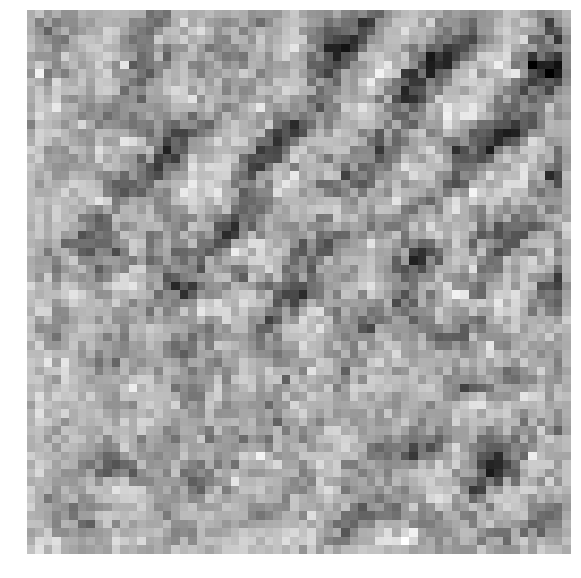

In [64]:
imm(test_out2[2,:,:,:].reshape((64,64)))

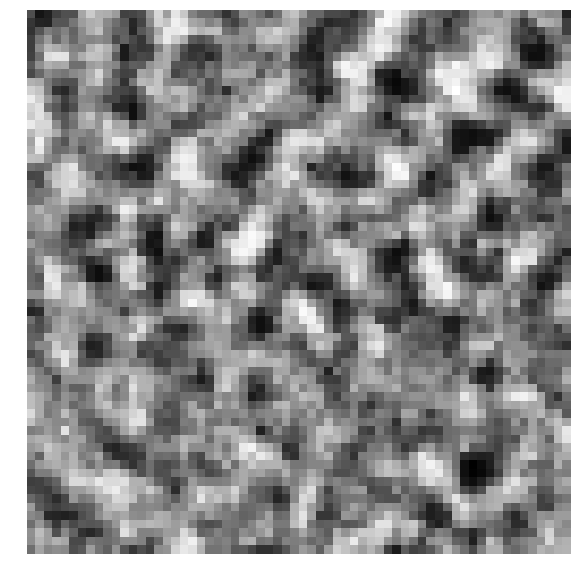

In [66]:
imm(trainX[2,:,:,:].reshape((64,64)))